In [10]:
import os
import sys
import numpy as np
import pandas as pd
from six.moves import cPickle as pickle
from HTMLParser import HTMLParser
from collections import Counter
import codecs
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import renders as rs
% matplotlib inline

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.SnowballStemmer('english')
def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [19]:
class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.flag = ''
        self.categs = dict()
        self.title = ''
    def handle_starttag(self, tag, attrs):
        d = dict(attrs)
        self.flag = ''
        if tag == 'meta' and d.get('name', '') != '':
            if d['name'] == 'description':
                self.categs['description'] = d['content']    
            if d['name'] == 'keywords':
                self.categs['keywords'] = d['content']
        if tag == 'title':
            self.flag = 'title'
    def handle_data(self, data):
        if self.flag == 'title':
            self.title = self.title + re.sub(r'\d+', '', re.sub(r"\W", "", data)).lower()

In [20]:
dir_path = './html_sample_dataset/am/'
files = [f for f in os.listdir(dir_path)]
f_cont = dict()
if os.path.exists('./data.pkl'):
    with open('data.pkl', 'r') as f:
        train_data = pickle.load(f)    
else:
    train_data = []
    for i, doc in enumerate(files):
        with codecs.open(dir_path + str(doc), 'r', 'utf-8') as f:
            content = f.read()
            f_cont[str(doc)] = content
    for k, v in f_cont.iteritems():
        parser = MyHTMLParser()
        parser.feed(v)
        train_data.append({'doc': k, 'description': parser.categs.get('description', ''), 'keywords': parser.categs.get('keywords', ''), 'title': parser.title})
    train_data = pd.DataFrame(train_data)
    with open('data.pkl', 'w') as f:
        pickle.dump(train_data, f)

In [21]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in train_data['description']:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))   
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['description'])

In [22]:
samples = train_data.sample(n = 5, random_state = 40)
for index, s in samples.iterrows():
    print s['title']
    print s['doc']
tfidf_samples = tfidf_vectorizer.transform(samples['description'])
terms = tfidf_vectorizer.get_feature_names()

amazonesayuda
000f38b3a5e44b735bef1548f8523ba6
amazoncomdrillingholdersindexableinsertholdersindustrialscientific
00228fba772b33581ff1c39acf1de430
amazoninallpendantspendantscoinsjewellery
002f4ffb333f18af2fd90d27848b26f0
babybibwithiloveiokepafirstnamesurnamenicknameamazoncoukbaby
00349531709c8d8ff39940fbcd844c33
amazonfrcommentairedepatrickbsuramazonbasicshautparleurnanobluetoothu
001d8525d90e1225a1f0186fe899b9ca


In [23]:
## I have sampled 5 documents and they are
## 1 - marketing page 
## 2 - listing page
## 3 - listing page
## 4 - product page
## 5 - Comment page

Score for 2 clusters is 0.530741462071
Score for 3 clusters is 0.634212594171
Score for 4 clusters is 0.804505128094
Score for 5 clusters is 1.0


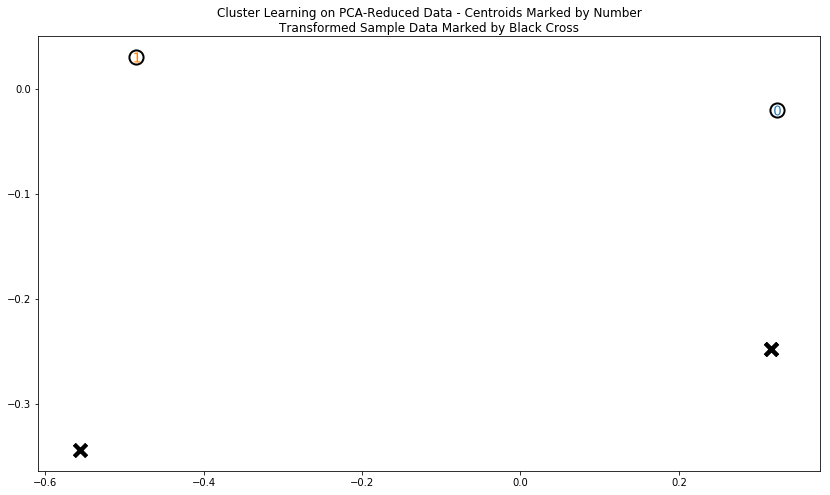

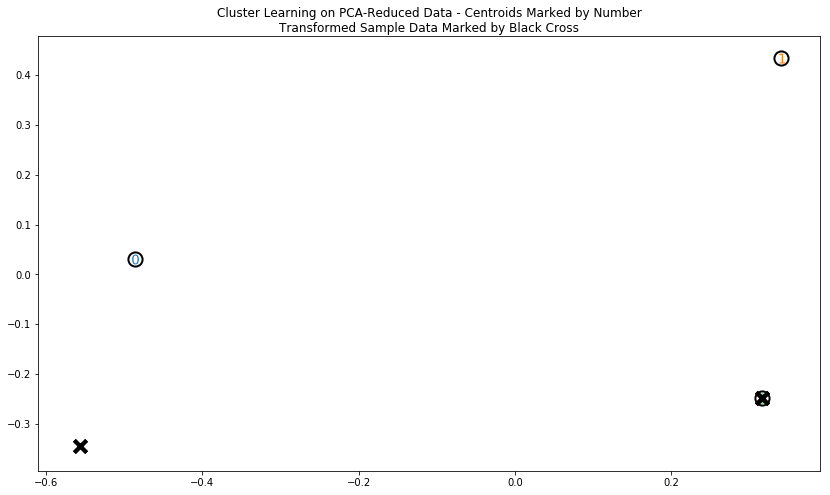

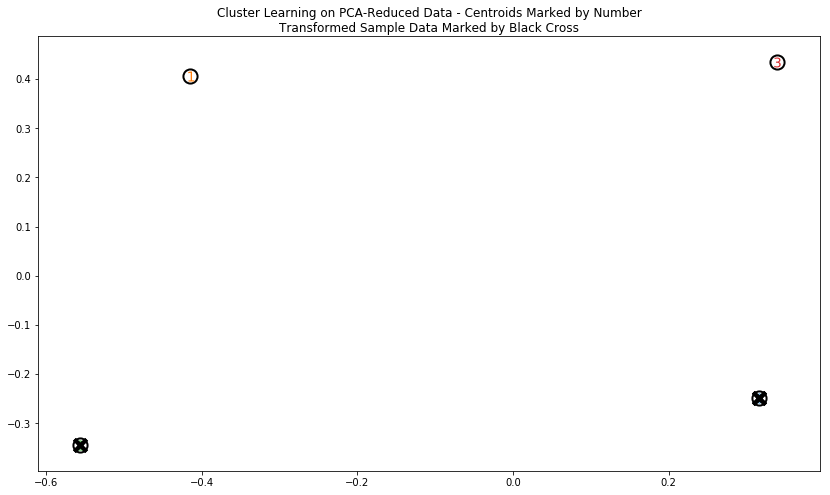

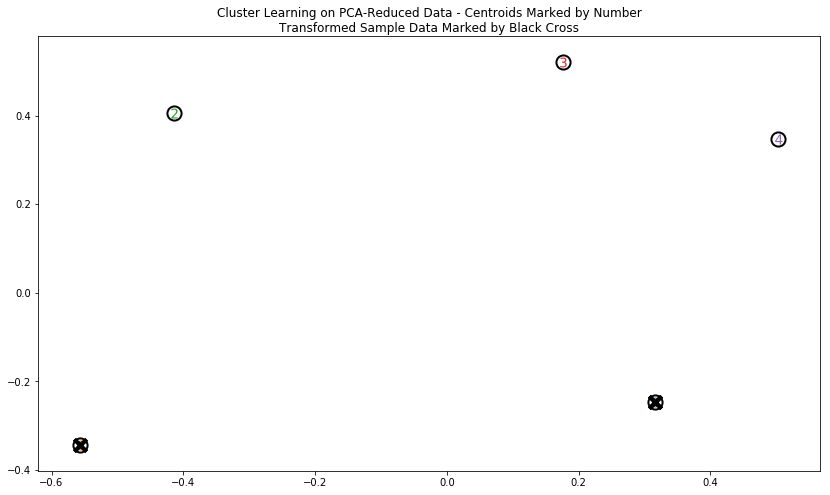

In [16]:
for i in [2, 3, 4, 5]:
    pca = PCA(n_components = i)
    pca.fit(tfidf_matrix.toarray())
    reduced_data = pca.transform(tfidf_matrix.toarray())
    pca_samples = pca.transform(tfidf_samples.toarray())
    model = KMeans(n_clusters=i)
    model.fit(reduced_data)
    clusters = model.predict(reduced_data)
    print "Score for {} clusters is {}".format(i, silhouette_score(reduced_data, clusters))
    frame = pd.DataFrame({'doc': train_data['doc'], 'title': train_data['title'], 'cluster': clusters}, index = [clusters] , columns = ['title', 'cluster'])
    centroids = model.cluster_centers_
    rs.cluster_results(pd.DataFrame(reduced_data), pd.DataFrame(clusters), centroids, pca_samples)
    order_centroids = pca.inverse_transform(centroids)
##    for n in range(i):
##        print"Cluster {} words:".format(n)
##        for ind in order_centroids[n, :6]:
##            print vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')   
##        print "Cluster {} titles:".format(n)
##        for title in frame.ix[n]['title'].values.tolist():
##            print title 